

## Predict if someone makes more or less than 50k using the adult dataset

   * Note that this dataset strictly refers to people living in the US






In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data_utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
# from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader 

In [2]:
# Loading the Training and Testing Data
adultdata = np.load('./Adult/data.npy').astype('float32')
adultlabels = np.load('./Adult/labels.npy').astype('float32')

## Normalizing  the data using the Formula (x-xmin/(xmax-xmin)) across each column

In [3]:
# # Normalizing the data by using the Formula (x-xmin/(xmax-xmin))
normadultdata=(adultdata-adultdata.min(axis=0))/(adultdata.max(axis=0)-adultdata.min(axis=0))

## Splitting and Loading Data in Data Loader
* Train Data Loader has shuffle = True, so that it can shuffle data in each minibatch every epoch. 

In [70]:
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(normadultdata,adultlabels, test_size=0.15, shuffle = True)

# batch_size
batch = 256

# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train))
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))
test_loader = data_utils.DataLoader(test,batch_size=batch)

# Showing the Training Data after Normalizing

In [5]:
# Preview the training data
for batch_idx, (data, target) in enumerate(train_loader):
#     print(batch_idx)
    print("Training Data")
    print(data[0])
    print("Testing Label")
    print(target[0].item())
    break
    

Training Data
tensor([0.5479, 0.6000, 0.0000, 0.0000, 0.3776, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Testing Label
0.0


## Defining Convolution Neural Network
* A simple fully connected network was used with activation function like ReLU and PReLU. 
* PReLU was used as it increased the accuracy, although this was very experimental, as replacing all the ReLUs by PreLU significantly reduce the accuracy.
* As this is a binary classification problem, Sigmoid Activation is Used in the final layer.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(67, 128)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(32, 1)
        self.out_act = nn.Sigmoid()
    
    def swish(self,x):
        return x * torch.sigmoid(x)
        
    def forward(self, input_):
        inp = self.fc1(input_)
        x = self.relu1(inp)
        x = self.dout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dout2(x)
        x = self.fc3(x)
        x = self.prelu(x)
        x = self.out(x)
        y = (self.out_act(x))
        return y
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=67, out_features=128, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dout2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [7]:
# summary(net,input_size = (1,67),batch_size=batch)

##  Define a Loss function and optimizer
* Binary Cross Entropy Loss is used as this is a binary classification problem.
* After Playing with optimizers, admam gave the Best accuracy.
* Below is a table of some of the things I tried and have logged training andtesting accuracy.
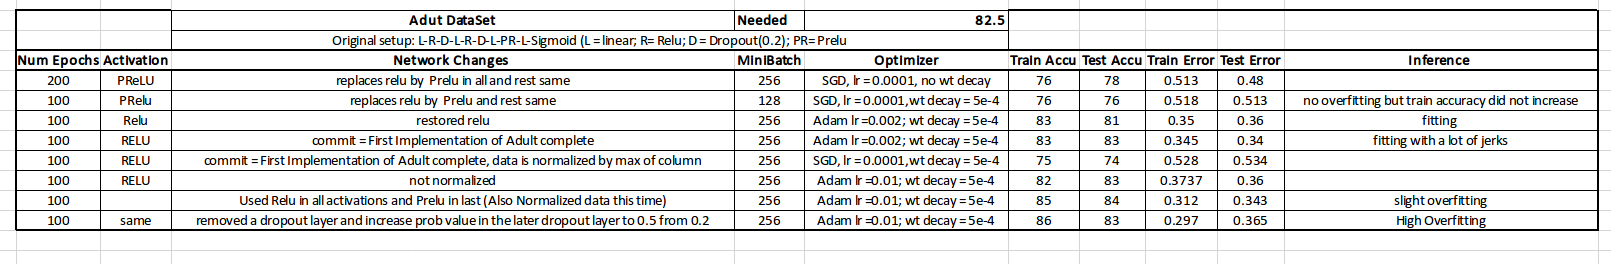
                                	
* From the above table, the original network gave the best accuracy with slight overfitting in 100 epochs. The use of dropout layers after every layer helped, but the droput was limited to 0.2. If this is increased to 0.5, the accuracy decreases.

In [8]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)#,weight_decay = 5e-4
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps = 1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [9]:
# output = net(data)
# #         print(target.dtype,output.dtype)
# target = target.view(-1,1)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()
# torch.sum(output==target)



## Training and Testing

In [10]:
def train(model, train_loader, optimizer, epoch,device):
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        target = target.view(-1,1)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_correct += torch.sum(torch.round(output)==target)
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            target = target.view(-1,1)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            correct += torch.sum(torch.round(output)==target)
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
device

device(type='cpu')

# Training the Model

In [12]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/38438 (0%)]	Loss: 0.706699
Train Epoch: 1 [5120/38438 (13%)]	Loss: 0.502772
Train Epoch: 1 [10240/38438 (26%)]	Loss: 0.470130
Train Epoch: 1 [15360/38438 (40%)]	Loss: 0.419303
Train Epoch: 1 [20480/38438 (53%)]	Loss: 0.389660
Train Epoch: 1 [25600/38438 (66%)]	Loss: 0.380809
Train Epoch: 1 [30720/38438 (79%)]	Loss: 0.285083
Train Epoch: 1 [35840/38438 (93%)]	Loss: 0.396789

Test set: Average loss: 0.3536, Accuracy: 5671/6784 (83%)

Train Epoch: 2 [0/38438 (0%)]	Loss: 0.336307
Train Epoch: 2 [5120/38438 (13%)]	Loss: 0.351362
Train Epoch: 2 [10240/38438 (26%)]	Loss: 0.354963
Train Epoch: 2 [15360/38438 (40%)]	Loss: 0.398020
Train Epoch: 2 [20480/38438 (53%)]	Loss: 0.374107
Train Epoch: 2 [25600/38438 (66%)]	Loss: 0.409919
Train Epoch: 2 [30720/38438 (79%)]	Loss: 0.342124
Train Epoch: 2 [35840/38438 (93%)]	Loss: 0.355420

Test set: Average loss: 0.3472, Accuracy: 5680/6784 (83%)

Train Epoch: 3 [0/38438 (0%)]	Loss: 0.310474
Train Epoch: 3 [5120/38438 (13%)]	Loss: 0.37323

Train Epoch: 19 [5120/38438 (13%)]	Loss: 0.332564
Train Epoch: 19 [10240/38438 (26%)]	Loss: 0.385870
Train Epoch: 19 [15360/38438 (40%)]	Loss: 0.336002
Train Epoch: 19 [20480/38438 (53%)]	Loss: 0.311353
Train Epoch: 19 [25600/38438 (66%)]	Loss: 0.311391
Train Epoch: 19 [30720/38438 (79%)]	Loss: 0.318739
Train Epoch: 19 [35840/38438 (93%)]	Loss: 0.366380

Test set: Average loss: 0.3309, Accuracy: 5727/6784 (84%)

Train Epoch: 20 [0/38438 (0%)]	Loss: 0.444182
Train Epoch: 20 [5120/38438 (13%)]	Loss: 0.357464
Train Epoch: 20 [10240/38438 (26%)]	Loss: 0.336429
Train Epoch: 20 [15360/38438 (40%)]	Loss: 0.362209
Train Epoch: 20 [20480/38438 (53%)]	Loss: 0.311903
Train Epoch: 20 [25600/38438 (66%)]	Loss: 0.354060
Train Epoch: 20 [30720/38438 (79%)]	Loss: 0.347745
Train Epoch: 20 [35840/38438 (93%)]	Loss: 0.353270

Test set: Average loss: 0.3359, Accuracy: 5711/6784 (84%)

Train Epoch: 21 [0/38438 (0%)]	Loss: 0.338565
Train Epoch: 21 [5120/38438 (13%)]	Loss: 0.342901
Train Epoch: 21 [10240/384


Test set: Average loss: 0.3309, Accuracy: 5730/6784 (84%)

Train Epoch: 37 [0/38438 (0%)]	Loss: 0.357619
Train Epoch: 37 [5120/38438 (13%)]	Loss: 0.304339
Train Epoch: 37 [10240/38438 (26%)]	Loss: 0.292992
Train Epoch: 37 [15360/38438 (40%)]	Loss: 0.366178
Train Epoch: 37 [20480/38438 (53%)]	Loss: 0.359653
Train Epoch: 37 [25600/38438 (66%)]	Loss: 0.288869
Train Epoch: 37 [30720/38438 (79%)]	Loss: 0.395812
Train Epoch: 37 [35840/38438 (93%)]	Loss: 0.364832

Test set: Average loss: 0.3328, Accuracy: 5725/6784 (84%)

Train Epoch: 38 [0/38438 (0%)]	Loss: 0.327665
Train Epoch: 38 [5120/38438 (13%)]	Loss: 0.321625
Train Epoch: 38 [10240/38438 (26%)]	Loss: 0.333228
Train Epoch: 38 [15360/38438 (40%)]	Loss: 0.297043
Train Epoch: 38 [20480/38438 (53%)]	Loss: 0.308423
Train Epoch: 38 [25600/38438 (66%)]	Loss: 0.303923
Train Epoch: 38 [30720/38438 (79%)]	Loss: 0.293733
Train Epoch: 38 [35840/38438 (93%)]	Loss: 0.283399

Test set: Average loss: 0.3348, Accuracy: 5726/6784 (84%)

Train Epoch: 39 

Train Epoch: 54 [30720/38438 (79%)]	Loss: 0.336595
Train Epoch: 54 [35840/38438 (93%)]	Loss: 0.287548

Test set: Average loss: 0.3360, Accuracy: 5721/6784 (84%)

Train Epoch: 55 [0/38438 (0%)]	Loss: 0.349122
Train Epoch: 55 [5120/38438 (13%)]	Loss: 0.375465
Train Epoch: 55 [10240/38438 (26%)]	Loss: 0.285206
Train Epoch: 55 [15360/38438 (40%)]	Loss: 0.330569
Train Epoch: 55 [20480/38438 (53%)]	Loss: 0.324023
Train Epoch: 55 [25600/38438 (66%)]	Loss: 0.352509
Train Epoch: 55 [30720/38438 (79%)]	Loss: 0.372309
Train Epoch: 55 [35840/38438 (93%)]	Loss: 0.276576

Test set: Average loss: 0.3371, Accuracy: 5719/6784 (84%)

Train Epoch: 56 [0/38438 (0%)]	Loss: 0.362921
Train Epoch: 56 [5120/38438 (13%)]	Loss: 0.307742
Train Epoch: 56 [10240/38438 (26%)]	Loss: 0.338373
Train Epoch: 56 [15360/38438 (40%)]	Loss: 0.374948
Train Epoch: 56 [20480/38438 (53%)]	Loss: 0.271468
Train Epoch: 56 [25600/38438 (66%)]	Loss: 0.342143
Train Epoch: 56 [30720/38438 (79%)]	Loss: 0.257548
Train Epoch: 56 [35840/38

Train Epoch: 72 [20480/38438 (53%)]	Loss: 0.293552
Train Epoch: 72 [25600/38438 (66%)]	Loss: 0.298332
Train Epoch: 72 [30720/38438 (79%)]	Loss: 0.353192
Train Epoch: 72 [35840/38438 (93%)]	Loss: 0.297516

Test set: Average loss: 0.3363, Accuracy: 5717/6784 (84%)

Train Epoch: 73 [0/38438 (0%)]	Loss: 0.336525
Train Epoch: 73 [5120/38438 (13%)]	Loss: 0.291729
Train Epoch: 73 [10240/38438 (26%)]	Loss: 0.304425
Train Epoch: 73 [15360/38438 (40%)]	Loss: 0.310811
Train Epoch: 73 [20480/38438 (53%)]	Loss: 0.317034
Train Epoch: 73 [25600/38438 (66%)]	Loss: 0.348059
Train Epoch: 73 [30720/38438 (79%)]	Loss: 0.309773
Train Epoch: 73 [35840/38438 (93%)]	Loss: 0.339192

Test set: Average loss: 0.3337, Accuracy: 5722/6784 (84%)

Train Epoch: 74 [0/38438 (0%)]	Loss: 0.309206
Train Epoch: 74 [5120/38438 (13%)]	Loss: 0.354975
Train Epoch: 74 [10240/38438 (26%)]	Loss: 0.301944
Train Epoch: 74 [15360/38438 (40%)]	Loss: 0.308787
Train Epoch: 74 [20480/38438 (53%)]	Loss: 0.336506
Train Epoch: 74 [25600/38

Train Epoch: 90 [10240/38438 (26%)]	Loss: 0.291698
Train Epoch: 90 [15360/38438 (40%)]	Loss: 0.288956
Train Epoch: 90 [20480/38438 (53%)]	Loss: 0.281906
Train Epoch: 90 [25600/38438 (66%)]	Loss: 0.295167
Train Epoch: 90 [30720/38438 (79%)]	Loss: 0.303087
Train Epoch: 90 [35840/38438 (93%)]	Loss: 0.305063

Test set: Average loss: 0.3364, Accuracy: 5709/6784 (84%)

Train Epoch: 91 [0/38438 (0%)]	Loss: 0.327403
Train Epoch: 91 [5120/38438 (13%)]	Loss: 0.310202
Train Epoch: 91 [10240/38438 (26%)]	Loss: 0.300217
Train Epoch: 91 [15360/38438 (40%)]	Loss: 0.379991
Train Epoch: 91 [20480/38438 (53%)]	Loss: 0.301034
Train Epoch: 91 [25600/38438 (66%)]	Loss: 0.293204
Train Epoch: 91 [30720/38438 (79%)]	Loss: 0.361498
Train Epoch: 91 [35840/38438 (93%)]	Loss: 0.270141

Test set: Average loss: 0.3480, Accuracy: 5680/6784 (83%)

Train Epoch: 92 [0/38438 (0%)]	Loss: 0.283088
Train Epoch: 92 [5120/38438 (13%)]	Loss: 0.251644
Train Epoch: 92 [10240/38438 (26%)]	Loss: 0.346696
Train Epoch: 92 [15360/38

Training Loss: 0.31262888103131425
Training Accuracy: tensor(85)

Test Loss: 0.3399182315225954
Testing Accuracy: tensor(84)



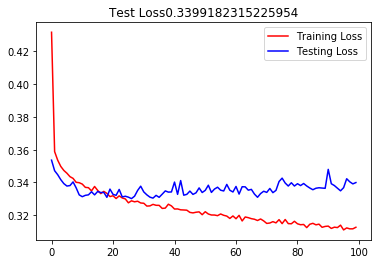

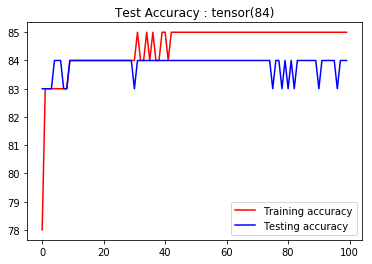

In [16]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', val_loss[-1])
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

# Incorrect Predictions


In [80]:
# Visualize Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))
visualize_loader = data_utils.DataLoader(test)

In [103]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output
for data, target in visualize_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========0`
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    neg = (torch.round(output)!=target).item()
    pred= torch.round(output).item()
    predictedlabel.append(pred)
    targetlabel.append(target)
    ind.append(neg)
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]
print("The Top 6 Wrong Predictions are as follows")
for i in range(n):
    print()
    print("Wrong Prediciton No "+ str(i+1))
    print ("Input: "+ str(X_test[maxerrorind[i]]))
    print("Predicted label"+ str(predictedlabel[[maxerrorind[i]]]))
    print("True label"+ str(targetlabel[[maxerrorind[i]]]))

    

/home/anirudh/anaconda2/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


The Top 6 Wrong Predictions are as follows

Wrong Prediciton No 1
Input: [0.10958904 0.8        0.         0.         0.39795917 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         0.         1.         0.         0.         0.
 0.        ]
Predicted label[1.]
True label[0.]

Wrong Prediciton No 2
Input: [0.15068494 0.8        0.         0.         0.5        0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

## Positive Predictions

In [104]:
ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]
print("Positive Predictions are as follows")
for i in range(n):
    print()
    print("Positive Prediciton No "+ str(i+1))
    print ("Input: "+ str(X_test[maxerrorind[i]]))
    print("Predicted label"+ str(predictedlabel[[maxerrorind[i]]]))
    print("True label"+ str(targetlabel[[maxerrorind[i]]]))


Positive Predictions are as follows

Positive Prediciton No 1
Input: [0.05479452 0.6        0.         0.25882354 0.1122449  0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.        ]
Predicted label[1.]
True label[1.]

Positive Prediciton No 2
Input: [0.01369863 0.4        0.         0.         0.23469388 0.
 0.         1.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0